In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
import matplotlib.colors as colors
import utils_load as il
from scipy.special import factorial
import MAS_library as MASL
import copy

import os
import sys

In [2]:
#The module that needs to be tested

#Necessary for relative imports (see https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im)
module_path = os.path.abspath(os.path.join('../../'))           # '../../' is needed because the parent directory is two directories upstream of this test directory
if module_path not in sys.path:
    sys.path.append(module_path)

from kNN_ASMR import HelperFunctions as hf
from kNN_ASMR.kNN_3D.kNN_3D import TracerFieldCross3D
from kNN_ASMR.kNN_3D.kNN_3D import TracerFieldCross3D_DataVector


In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13})
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.linewidth"] = 2*0.8
plt.rcParams["xtick.major.width"] = 2*0.6
plt.rcParams["ytick.major.width"] = 2*0.6
plt.rcParams["xtick.major.size"] = 1.5*3.5
plt.rcParams["ytick.major.size"] = 1.5*3.5
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.minor.width"] = 2*0.4
plt.rcParams["ytick.minor.width"] = 2*0.4
plt.rcParams["xtick.minor.size"] = 1.5*1.5
plt.rcParams["ytick.minor.size"] = 1.5*1.5
prop_cycle = plt.rcParams['axes.prop_cycle']
BrightColors = ['cyan', 'yellow', 'lime', '#E0B0FF']



## Function Definitions

In [4]:
# Read halo catalog
def read_catalog(BASE_PATH, ngal):
    fields = ['GroupMass', 'GroupCM', 'GroupVel']
    halos = il.loadHalos(BASE_PATH, 50, fields=fields)
    
    print(f"Read {len(halos['GroupCM'])} halos from {BASE_PATH}")
    
    if ngal ==0:
        halo_pos  = halos['GroupCM'] / 1.0e3  # Convert to Mpc/h - all halos
        print(f"Selected all {len(halo_pos)} halos")

    else:
        idx = np.argsort(halos['GroupMass'])[-ngal:][::-1] # Select the top ngal halos by mass
        halo_pos = halos['GroupCM'][idx] / 1.0e3  # Convert to Mpc/h
        print(f"Selected {ngal} halos")

    return halo_pos.astype(np.float32)

In [5]:
from scipy.special import factorial
import numpy as np

def PoissonUniformCDFs(nbar, R_array, k):
    
    cdf_vals = np.zeros_like(R_array)

    for j, R in enumerate(R_array):
        lam     = (4/3) * np.pi * R**3 * nbar  # Poisson rate (expected count in volume)
        exp_lam = np.exp(-lam)
        total   = 0.0
        for i in range(k):  # P(N < k) = sum_{i=0}^{k-1} Poiss(i; λ)
            total += (lam**i / factorial(i, exact=False)) * exp_lam
        cdf_vals[j] = total

    return 1 - cdf_vals


In [6]:
def downgrade_field_block_average(field_highres, factor):
    """
    Downgrade a 3D field by block averaging.

    Parameters:
    - field_highres: ndarray of shape (N, N, N), e.g. (512, 512, 512)
    - factor: int, e.g. 2 to go from 512 → 128

    Returns:
    - field_lowres: ndarray of shape (N//factor, N//factor, N//factor)
    """
    N = field_highres.shape[0]
    assert N % factor == 0, "Grid size must be divisible by factor."

    # Reshape to (N//f, f, N//f, f, N//f, f)
    reshaped = field_highres.reshape(
        N//factor, factor,
        N//factor, factor,
        N//factor, factor
    )

    # Average over each block
    field_lowres = reshaped.mean(axis=(1, 3, 5))
    return field_lowres

## Main

In [7]:
# Properties
BoxSize = 205.0  # Mpc/h
ngal    = 4000
nbar    = ngal / (BoxSize**3)  # Number density of galaxies
print(f"Number density of galaxies: {nbar:.2e} h^3 Mpc^-3")

Number density of galaxies: 4.64e-04 h^3 Mpc^-3


### Loading Datasets

In [8]:
import os
print(os.path.exists('/Users/hermoine/Documents/PROJECTS/kNN-Samrajya/Datasets/illustris_data'))

True


In [9]:
# Data Files - IllustrisTNG-300 Simulation at redshift z = 1
BASE_PATH = '/Users/hermoine/Documents/PROJECTS/kNN-Samrajya/Datasets/illustris_data/'
# halo_pos     = read_catalog(BASE_PATH, ngal)


In [10]:
# np.save(f'/Users/hermoine/Documents/PROJECTS/kNN-Samrajya/Datasets/illustris_data/HaloPos_4kMostMassive.npy', halo_pos)
halo_pos = np.load(f'{BASE_PATH}/HaloPos_4kMostMassive.npy')

In [11]:
# SIGNAL_FILE = f'{BASE_PATH}/signal.npy'
# Tb_field     = np.load(SIGNAL_FILE)

In [12]:
# print(f"Signal field shape: {Tb_field.shape}")
# grid    = Tb_field.shape[0]  # Assuming cubic grid
# print(f" Properties of Tb_field: min={Tb_field.min():.2e}, max={Tb_field.max():.2e}, mean={Tb_field.mean():.2e}, std={Tb_field.std():.2e}")

In [13]:
# Downgrading the field 
# np.save(f'/Users/hermoine/Documents/PROJECTS/kNN-Samrajya/Datasets/illustris_data/Tb_downgrade_field.npy', Tb_downgrade_field)
Tb_downgrade_field = np.load(f'{BASE_PATH}/Tb_downgrade_field.npy')
grid    = Tb_downgrade_field.shape[0]  # Assuming cubic grid
print('grid:', grid)



grid: 256


In [14]:
print(f"Downgraded Signal field shape: {Tb_downgrade_field.shape}")
print(f" Properties of Tb_downgrade_field: min={Tb_downgrade_field.min():.2e}, max={Tb_downgrade_field.max():.2e}, mean={Tb_downgrade_field.mean():.2e}, std={Tb_downgrade_field.std():.2e}")

Downgraded Signal field shape: (256, 256, 256)
 Properties of Tb_downgrade_field: min=2.29e-09, max=2.04e+02, mean=1.18e-01, std=1.02e+00


In [15]:
# Prepare for plotting
xi = 0; xf = 4.0
fg = int(xf * grid/BoxSize); print(f'final grid corresponding to xf = {xf} Mpc/h:', fg)  # Final grid size in Mpc/h
mask = (halo_pos[:, 0] >= xi) & (halo_pos[:, 0] <= xf)


final grid corresponding to xf = 4.0 Mpc/h: 4


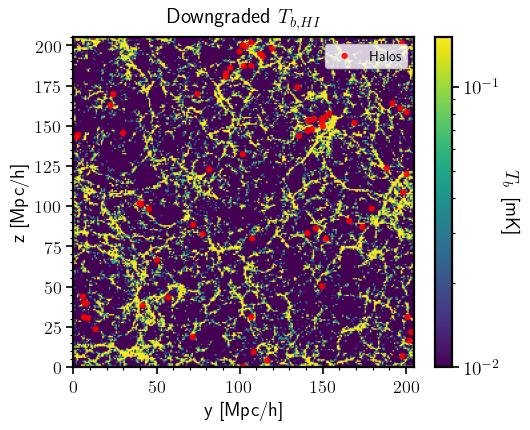

In [16]:
# Plot imshow for Tb_field
fig, ax = plt.subplots(1,1, figsize=(5.5, 4.5))

im2 = ax.imshow(np.mean(Tb_downgrade_field[xi:fg], axis = 0), origin='lower', cmap='viridis', aspect='auto',
               extent=[0, BoxSize, 0, BoxSize], norm=colors.LogNorm(vmin=0.01, vmax=0.15))

ax.scatter(halo_pos[mask, 1], halo_pos[mask, 2], s=20, c='red', alpha=0.9, label='Halos', edgecolors='none')

cbar = fig.colorbar(im2, ax=ax, orientation='vertical')
cbar.set_label(r'$T_b$ \,[mK]', rotation=270, labelpad=14)
cbar.ax.tick_params(labelsize=14)

ax.set_title(r'Downgraded $T_{b,HI}$', pad=10)

ax.set_xlabel(r'y [Mpc/h]')
ax.set_ylabel(r'z [Mpc/h]')
ax.legend(fontsize = 10)

plt.tight_layout()
plt.show()


### Query Points


In [17]:
# Generate query positions
nquery = 256**3
np.random.seed(0)
query_pos = (np.random.rand(nquery, 3) * BoxSize).astype(np.float32) % BoxSize

## Testing

### Bins well measured for Poisson-data CDFs

In [18]:
k_list = [1, 2, 4]
r_max = 20
num_r = 25
Rbins = np.zeros((len(k_list), num_r))

for i, k in enumerate(k_list):
    Rbins[i] = np.linspace(0, r_max, num_r)

Theoretical_Uniform_CDFs_test = []

for i, k in enumerate(k_list):
    Theoretical_Uniform_CDFs_test.append(PoissonUniformCDFs(nbar, Rbins[i], k))


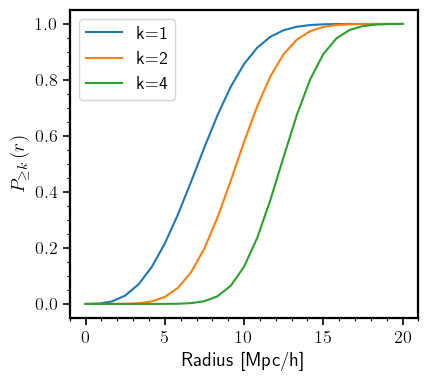

In [19]:
plt.figure(figsize=(4.5, 4))
for i, k in enumerate(k_list):
    plt.plot(Rbins[i], Theoretical_Uniform_CDFs_test[i], label=f'k={k}')

plt.xlabel('Radius [Mpc/h]')
plt.ylabel(r'$P_{\geq k} \,(r)$')
plt.legend()
plt.show()
plt.close()

In [20]:
low_bin  = np.zeros(len(k_list)).astype(int)
high_bin = np.zeros(len(k_list)).astype(int)

for i, k in enumerate(k_list):
    low_bin[i]  = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.05)
    high_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.95)
    print(f'{k}NN', '{:.2f}'.format(Rbins[i][low_bin[i]]), '{:.2f}'.format(Rbins[i][high_bin[i]]))

num_Rbins  = 10
Rbins_pick = np.zeros((len(k_list), num_Rbins))

for i, k in enumerate(k_list):
    Rbins_pick[i] = np.linspace(Rbins[i][low_bin[i]]*0.95, Rbins[i][high_bin[i]]*1.05, num_Rbins)

for i, k in enumerate(k_list):
    print(f'\nRadial bins for {k}NN-CDF:\n', Rbins_pick[i])
    print(f'\nNumber of bins for {k}NN-CDF: ', len(Rbins_pick[i]))


1NN 3.33 11.67
2NN 5.83 14.17
4NN 9.17 16.67

Radial bins for 1NN-CDF:
 [ 3.16666667  4.17592593  5.18518519  6.19444444  7.2037037   8.21296296
  9.22222222 10.23148148 11.24074074 12.25      ]

Number of bins for 1NN-CDF:  10

Radial bins for 2NN-CDF:
 [ 5.54166667  6.5787037   7.61574074  8.65277778  9.68981481 10.72685185
 11.76388889 12.80092593 13.83796296 14.875     ]

Number of bins for 2NN-CDF:  10

Radial bins for 4NN-CDF:
 [ 8.70833333  9.68518519 10.66203704 11.63888889 12.61574074 13.59259259
 14.56944444 15.5462963  16.52314815 17.5       ]

Number of bins for 4NN-CDF:  10


In [21]:
Theory_CDFs = np.zeros((len(k_list), Rbins_pick.shape[1]))

for i, k in enumerate(k_list):
    Theory_CDFs[i] = PoissonUniformCDFs(nbar, Rbins_pick[i], k)

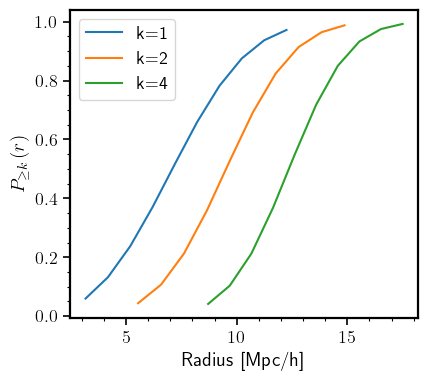

In [22]:
plt.figure(figsize=(4.5, 4))

for i, k in enumerate(k_list):
    plt.plot(Rbins_pick[i], Theory_CDFs[i], label=f'k={k}')

plt.xlabel('Radius [Mpc/h]')
plt.ylabel(r'$P_{\geq k} \,(r)$')
plt.legend()
plt.show()
plt.close()

### Testing kNN_3D.TracerFieldCross3D

In [23]:
delta_threshold = 75.0

In [24]:
# For actual halo positions - Compute the tracer-field cross-correlation
auto_halos, auto_field, joint = TracerFieldCross3D(k_list, Rbins_pick, BoxSize, query_pos, halo_pos, Tb_downgrade_field, delta_threshold, ReturnSmoothedFieldDict=False, Verbose=True)

Checking inputs ...
	done.

initiating step 1 ...

	building the kdTree ...
		done; time taken: 1.36e-03 s.

	computing the tracer NN distances ...
		done; time taken: 5.59e+00 s.

	computing P_{>=k} ...
		done; time taken: 7.84e+00 s.
time taken for step 1: 1.34e+01 s.

initiating step 2 ...

Computing P_{>=k, >dt} and P_{>dt} for k = 1 ...
	done for k = 1; time taken: 1.08e+01 s

Computing P_{>=k, >dt} and P_{>dt} for k = 2 ...
	done for k = 2; time taken: 1.10e+01 s

Computing P_{>=k, >dt} and P_{>dt} for k = 4 ...
	done for k = 4; time taken: 1.11e+01 s

Total time taken: 3.30e+01 s

Total time taken for all steps: 4.64e+01 s


In [25]:
auto_halos = np.array(auto_halos)
auto_field = np.array(auto_field)
joint = np.array(joint)

# Shape
print(f'auto_halos shape:', auto_halos.shape)
print(f'auto_field shape:', auto_field.shape)
print(f'joint shape:', joint.shape)

auto_halos shape: (3, 10)
auto_field shape: (3, 10)
joint shape: (3, 10)


In [26]:
# Check on Random positions - Excess CDF should be close to 0 
rndm_pos = np.random.rand(ngal, 3) * BoxSize

# Compute the tracer-field cross-correlation
auto_rndm, auto_field_rndm, joint_rndm = TracerFieldCross3D(k_list, Rbins_pick, BoxSize, query_pos, rndm_pos, Tb_downgrade_field, delta_threshold, ReturnSmoothedFieldDict=False, Verbose=True) 

Checking inputs ...
	done.

initiating step 1 ...

	building the kdTree ...
		done; time taken: 2.13e-03 s.

	computing the tracer NN distances ...
		done; time taken: 5.31e+00 s.

	computing P_{>=k} ...
		done; time taken: 7.20e+00 s.
time taken for step 1: 1.25e+01 s.

initiating step 2 ...

Computing P_{>=k, >dt} and P_{>dt} for k = 1 ...
	done for k = 1; time taken: 1.02e+01 s

Computing P_{>=k, >dt} and P_{>dt} for k = 2 ...
	done for k = 2; time taken: 1.08e+01 s

Computing P_{>=k, >dt} and P_{>dt} for k = 4 ...
	done for k = 4; time taken: 1.09e+01 s

Total time taken: 3.18e+01 s

Total time taken for all steps: 4.44e+01 s


In [27]:
auto_rndm       = np.array(auto_rndm)
auto_field_rndm = np.array(auto_field_rndm)
joint_rndm      = np.array(joint_rndm)

# Shape
print(f'auto_rndms shape:', auto_rndm.shape)
print(f'auto_field_rndm shape:', auto_field_rndm.shape)
print(f'joint_rndm shape:', joint_rndm.shape)

auto_rndms shape: (3, 10)
auto_field_rndm shape: (3, 10)
joint_rndm shape: (3, 10)


In [28]:
# Checking the fiel auto CDFs
assert np.allclose(auto_field, auto_field_rndm), "Auto field for halos and randoms should be equal"

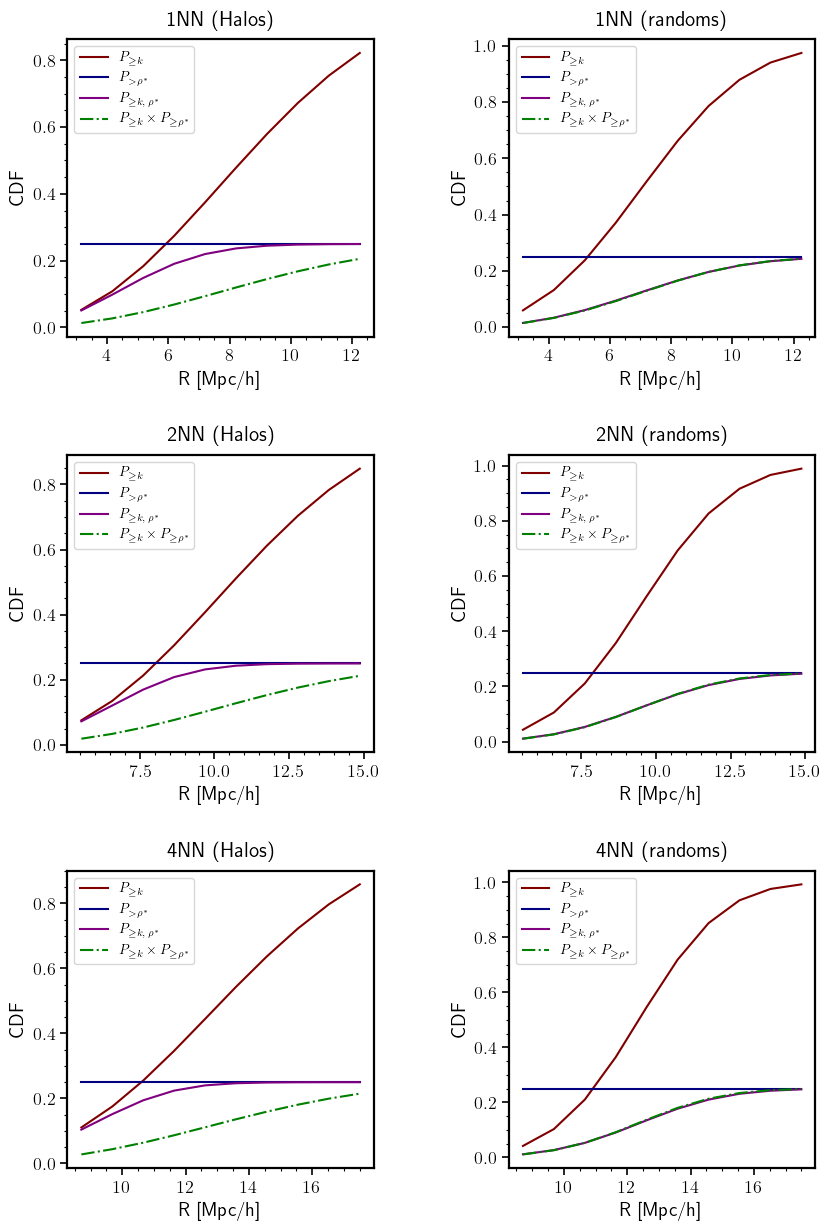

In [29]:
# Plotting the results - Halos
fig, ax = plt.subplots(3, 2, figsize=(8.5, 12.5))
axs = ax.flatten()
for i, k in enumerate(k_list):

    ax[i,0].plot(Rbins_pick[i], auto_halos[i], ls = '-', color='maroon', label = r'$P_{\geq k}$')
    ax[i,0].plot(Rbins_pick[i], auto_field[i], ls = '-', color='navy', label= r'$P_{> \rho^*}$')
    ax[i,0].plot(Rbins_pick[i], joint[i], ls='-', color='purple', label=r'$P_{\geq k,\, \rho^*}$')
    ax[i,0].plot(Rbins_pick[i], auto_halos[i] * auto_field[i], ls='-.', color='g', label =r'$P_{\geq k} \times P_{\geq \rho^*}$')
                 
    ax[i,1].plot(Rbins_pick[i], auto_rndm[i], ls = '-', color='maroon', label = r'$P_{\geq k}$')
    ax[i,1].plot(Rbins_pick[i], auto_field_rndm[i], ls = '-', color='navy', label= r'$P_{> \rho^*}$')
    ax[i,1].plot(Rbins_pick[i], joint_rndm[i], ls='-', color='purple', label=r'$P_{\geq k,\, \rho^*}$')
    ax[i,1].plot(Rbins_pick[i], auto_rndm[i] * auto_field_rndm[i], ls='-.', color='g', label =r'$P_{\geq k} \times P_{\geq \rho^*}$')    

    ax[i,0].set_title(f'{k}NN (Halos)', pad = 10)
    ax[i,1].set_title(f'{k}NN (randoms)', pad = 10)

for i in range(len(axs)):
    axs[i].set_xlabel(r'R [Mpc/h]')
    axs[i].set_ylabel(f'CDF')
    axs[i].legend(fontsize = 10)

plt.tight_layout(w_pad = 4, h_pad = 2)
plt.show()
# plt.close

In [30]:
excess_halos = hf.kNN_excess_cross_corr(auto_halos, auto_field, joint)
excess_rndm = hf.kNN_excess_cross_corr(auto_rndm, auto_field_rndm, joint_rndm)

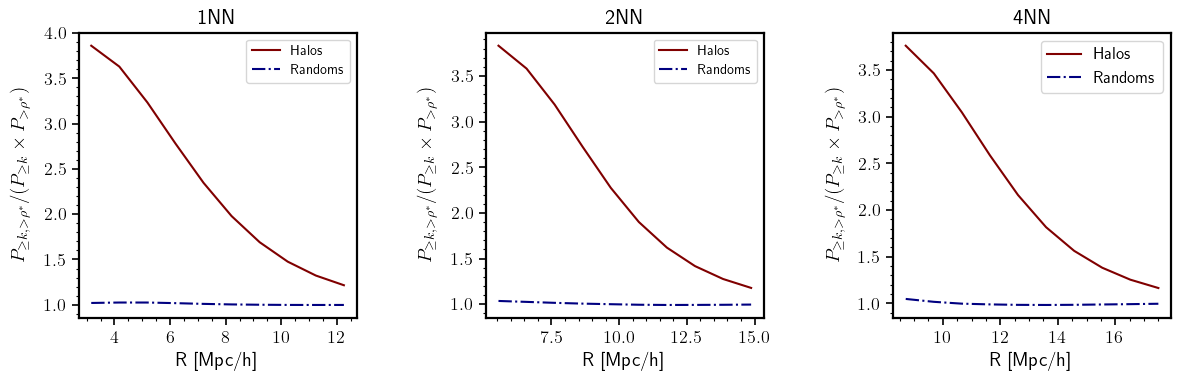

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, k in enumerate(k_list):

    ax[i].plot(Rbins_pick[i], excess_halos[i], color = 'maroon', ls='-', label='Halos')
    
    ax[i].plot(Rbins_pick[i], excess_rndm[i], color = 'navy', ls = '-.', label='Randoms')
    
    ax[i].set_xlabel(r'R [Mpc/h]')
    ax[i].set_ylabel(r'$P_{\geq k, > \rho^*}/ (P_{\geq k} \times P_{>\rho^*})$', labelpad = 10)
    ax[i].set_title(f'{k}NN')
    ax[i].legend(fontsize = 10)

plt.legend(fontsize=12)
plt.tight_layout(w_pad = 3, h_pad = 1)
plt.show()

### Testing kNN_3D.TracerFieldCross3D_DataVector

In [32]:
delta_threshold = 75.0

In [33]:
# Generate 10 realisations of random positions
n_realisations   = 10
tracer_pos       = np.zeros((n_realisations+1, ngal, 3), dtype=np.float32) # 1st index for halo pos
tracer_pos[0]    = halo_pos # First index is for halo positions
tracer_pos[1:]   = np.random.rand(n_realisations, ngal, 3) * BoxSize

In [34]:
print(query_pos.shape)

(16777216, 3)


In [35]:
auto_TracerCdf_nr, auto_FieldCdf_nr, joint_TrF_nr = TracerFieldCross3D_DataVector(k_list, Rbins_pick, BoxSize, query_pos, tracer_pos, Tb_downgrade_field, delta_threshold, ReturnSmoothedDict=False, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (smoothing the continuous field at the given radial scales)...
	done; time taken for step 1: 1.20e+01 s.

initiating step 2 (looping the tracer-field cross-correlation computations over the multiple tracer realisations)...


--------------  Realisation 1/11  --------------


building the kdTree for the discrete tracer set ...
	done; time taken: 1.56e-03 s.

computing the tracer NN distances ...
	done; time taken: 2.89e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 7.84e+00 s.

computing the tracer-field cross-correlation ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...
	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...
	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...

	done; time taken: 2.65e+01 s.

time taken for realisation 1: 6.32e+01 s.


--------------  Realisation 2/11  --------------


building the kdTree for the discrete tracer set ...
	done; time taken: 7.43e-03 s.

computing the tracer NN distances ...

In [36]:
print('Auto-cdf Trcer: ',np.shape(auto_TracerCdf_nr)); auto_TracerCdf_nr = np.array(auto_TracerCdf_nr); print(auto_TracerCdf_nr.shape)
print('\nAuto-cdf Field: ',np.shape(auto_FieldCdf_nr)); auto_FieldCdf_nr = np.array(auto_FieldCdf_nr); print(auto_FieldCdf_nr.shape)
print('\nJoint Tracer-Field',np.shape(joint_TrF_nr)); joint_TrF_nr = np.array(joint_TrF_nr); print(joint_TrF_nr.shape)

Auto-cdf Trcer:  (3, 11, 10)
(3, 11, 10)

Auto-cdf Field:  (3, 10)
(3, 10)

Joint Tracer-Field (3, 11, 10)
(3, 11, 10)


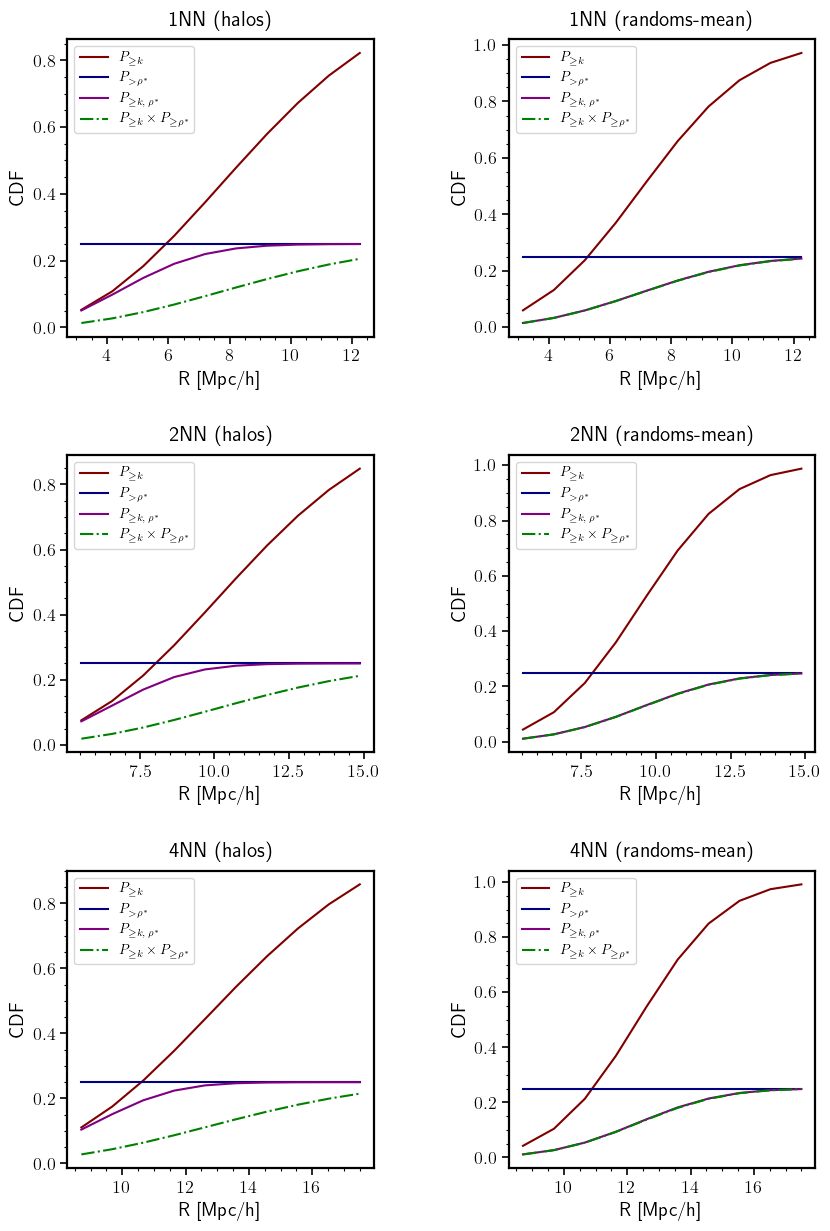

In [37]:
# Plotting the results - Halos
fig, ax = plt.subplots(3, 2, figsize=(8.5, 12.5))
axs = ax.flatten()
for i, k in enumerate(k_list):

    ax[i,0].plot(Rbins_pick[i], auto_TracerCdf_nr[i,0], ls = '-', color='maroon', label = r'$P_{\geq k}$')
    ax[i,0].plot(Rbins_pick[i], auto_FieldCdf_nr[i], ls = '-', color='navy', label= r'$P_{> \rho^*}$')
    ax[i,0].plot(Rbins_pick[i], joint_TrF_nr[i,0], ls='-', color='purple', label=r'$P_{\geq k,\, \rho^*}$')
    ax[i,0].plot(Rbins_pick[i], auto_TracerCdf_nr[i,0] * auto_FieldCdf_nr[i], ls='-.', color='g', label =r'$P_{\geq k} \times P_{\geq \rho^*}$')
                 
    ax[i,1].plot(Rbins_pick[i], np.mean(auto_TracerCdf_nr[i,1:], axis = 0), ls = '-', color='maroon', label = r'$P_{\geq k}$')
    ax[i,1].plot(Rbins_pick[i], auto_FieldCdf_nr[i], ls = '-', color='navy', label= r'$P_{> \rho^*}$')
    ax[i,1].plot(Rbins_pick[i], np.mean(joint_TrF_nr[i,1:], axis = 0), ls='-', color='purple', label=r'$P_{\geq k,\, \rho^*}$')
    ax[i,1].plot(Rbins_pick[i], np.mean(auto_TracerCdf_nr[i,1:], axis = 0) * auto_FieldCdf_nr[i], ls='-.', color='g', label =r'$P_{\geq k} \times P_{\geq \rho^*}$')    

    ax[i,0].set_title(f'{k}NN (halos)', pad = 10)
    ax[i,1].set_title(f'{k}NN (randoms-mean)', pad = 10)

for i in range(len(axs)):
    axs[i].set_xlabel(r'R [Mpc/h]')
    axs[i].set_ylabel(f'CDF')
    axs[i].legend(fontsize = 10)

plt.tight_layout(w_pad = 4, h_pad = 2)
plt.show()
# plt.close

In [38]:
# Compute Excess-CDF
excess_TrF = hf.kNN_excess_cross_corr(auto_TracerCdf_nr, auto_FieldCdf_nr, joint_TrF_nr)

In [39]:
print('Excess-CDF shape:', np.shape(excess_TrF)); excess_TrF = np.array(excess_TrF); print(excess_TrF.shape)

Excess-CDF shape: (3, 11, 10)
(3, 11, 10)


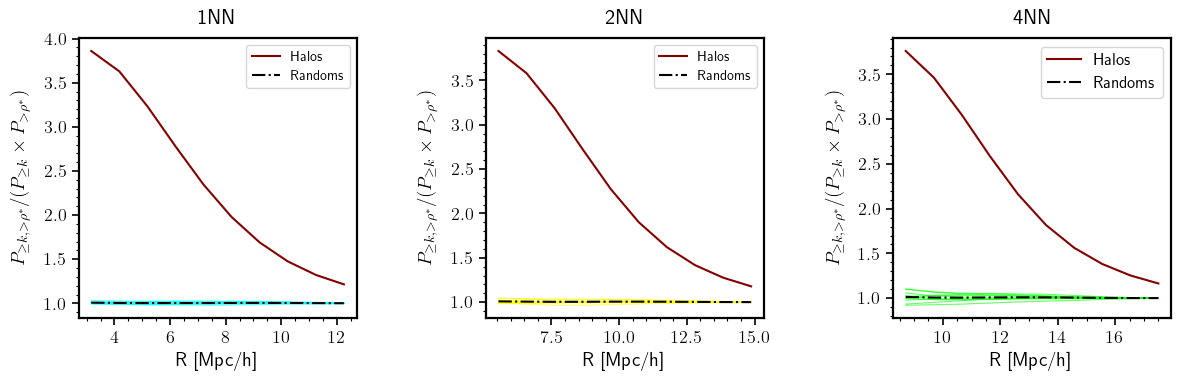

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, k in enumerate(k_list):

    ax[i].plot(Rbins_pick[i], excess_TrF[i][0], color = 'maroon', ls='-', label='Halos')
        
    for realisation in range(n_realisations):
        ax[i].plot(Rbins_pick[i], excess_TrF[i][1:][realisation], c=BrightColors[i], lw=0.8, alpha=0.6, label=None)
    
    ax[i].plot(Rbins_pick[i], np.mean(excess_TrF[i][1:], axis=0), color = 'black', ls = '-.', label='Randoms')
      
    
    ax[i].set_xlabel(r'R [Mpc/h]')
    ax[i].set_ylabel(r'$P_{\geq k, > \rho^*}/ (P_{\geq k} \times P_{>\rho^*})$', labelpad = 10)
    ax[i].set_title(f'{k}NN', pad = 10)
    ax[i].legend(fontsize = 10)

plt.legend(fontsize=12)
plt.tight_layout(w_pad = 3, h_pad = 1)
plt.show()